# Advanced Certification Program in Computational Data Science
## A program by IISc and TalentSprint
### Mini-Project: End-to-end analytics application using Pyspark

## Problem Statement

Perform sentiment classification by analyzing the tweets data with Pyspark

## Learning Objectives

At the end of the mini-project, you will be able to :

* analyze the text data using pyspark
* derive the insights and visualize the data
* implement feature extraction and classify the data
* train the classification model and deploy

### Dataset

The dataset chosen for this mini-project is **[Twitter US Airline Sentiment](https://data.world/socialmediadata/twitter-us-airline-sentiment)**. It is a record of tweets about airlines in the US. It was created by scraping Twitter data from February 2015. Contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").  Along with other information, it contains ID of a Tweet, the sentiment of a tweet ( neutral, negative and positive), reason for a negative tweet, name of airline and text of a tweet.

## Information

The airline industry is a very competitive market that has grown rapidly in the past 2 decades. Airline companies resort to traditional customer feedback forms which in turn are very tedious and time consuming. This is where Twitter data serves as a good source to gather customer feedback tweets and perform sentiment analysis. This dataset comprises of tweets for 6 major US Airlines and a multi-class classification can be performed to categorize the sentiment (neutral, negative, positive). For this mini-project we will start with pre-processing techniques to clean the tweets and then represent these tweets as vectors. A classification algorithm will be used to predict the sentiment for unseen tweets data. The end-to-end analytics will be performed using Pyspark.

## Grading = 10 Points

Install Spark

In [1]:
# --- Fast Spark Setup in Colab (with aria2) ---

# 1. Install Java 11 (Colab usually already has it, but just in case)
!apt-get -qq update
!apt-get -qq install -y openjdk-11-jdk-headless

# 2. Install aria2 for fast parallel downloads
!apt-get -qq install -y aria2

# 3. Download Spark 3.5.1 (Hadoop 3 build) quickly using mirrors + parallel connections
!aria2c -q -c -x16 -s16 -k1M --file-allocation=none \
  -o spark-3.5.1-bin-hadoop3.tgz \
  'https://www.apache.org/dyn/closer.lua/spark/spark-3.5.1/spark-3.5.1-bin-hadoop3.tgz?action=download' \
  'https://archive.apache.org/dist/spark/spark-3.5.1/spark-3.5.1-bin-hadoop3.tgz'

# 4. Extract Spark
!tar xf spark-3.5.1-bin-hadoop3.tgz

# 5. Set environment variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.1-bin-hadoop3"

# 6. Install Python dependencies
!pip install -q findspark pyspark==3.5.1 handyspark numpy

# 7. Initialize findspark
import findspark
findspark.init()

print(" Fast Spark setup complete")

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package libc-ares2:amd64.
(Reading database ... 126374 files and directories currently installed.)
Preparing to unpack .../libc-ares2_1.18.1-1ubuntu0.22.04.3_amd64.deb ...
Unpacking libc-ares2:amd64 (1.18.1-1ubuntu0.22.04.3) ...
Selecting previously unselected package libaria2-0:amd64.
Preparing to unpack .../libaria2-0_1.36.0-1_amd64.deb ...
Unpacking libaria2-0:amd64 (1.36.0-1) ...
Selecting previously unselected package aria2.
Preparing to unpack .../aria2_1.36.0-1_amd64.deb ...
Unpacking aria2 (1.36.0-1) ...
Setting up libc-ares2:amd64 (1.18.1-1ubuntu0.22.04.3) ...
Setting up libaria2-0:amd64 (1.36.0-1) ...
Setting up aria2 (1.36.0-1) ...
Processing triggers for man-db (2.10.2-1) ...
Processing triggers for libc-bin (2.35-0ubuntu3.8) ...
/sbin/ldconfig.real: /usr/l

**Note: The above code cell will take around 8 mins 30 secs for execution.**


#### Install Pyspark

In [2]:
#@title Install packages and download the dataset
!pip -qq install pyspark
!pip -qq install handyspark
!wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/US_Airline_Tweets.csv
print("Packages installed successfully and dataset downloaded!!")

Packages installed successfully and dataset downloaded!!


In [3]:
#from handyspark import *
import findspark
findspark.init()

In [4]:
import numpy as np
np.bool = np.bool_

### Import Handyspark

In [5]:
!pip install numpy==2.3.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 96.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.0 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.0 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.3.0 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.0 which is incompatible.
cupy-cuda12x 13.3.0 requires numpy<2.3,>=1.2

In [1]:
import handyspark

#### Import required packages

In [2]:
import os
import numpy as np
import pandas as pd
# fixes issue with seaborn hiding fliers on boxplot
import matplotlib as mpl
%matplotlib inline

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from handyspark import *
import seaborn as sns
from matplotlib import pyplot as plt
import re
import string
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.classification import NaiveBayes
from pyspark.sql.types import ArrayType, StringType
import warnings
warnings.filterwarnings("ignore")

In [3]:
# NLTK imports
import nltk
nltk.download('punkt')
# Download stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab') # Download punkt_tab resource
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


### Data Loading

#### Start a Spark Session

Spark session is a combined entry point of a Spark application, which came into implementation from Spark 2.0. It provides a way to interact with various Spark functionalities, with a lesser number of constructs.

In [4]:
# YOUR CODE HERE
from pyspark.sql import SparkSession

# Create or get existing Spark Session
spark = SparkSession.builder \
    .appName("MySparkApp") \
    .config("spark.some.config.option", "config-value") \
    .getOrCreate()

# Verify session
print("Spark Session started:", spark)

Spark Session started: <pyspark.sql.session.SparkSession object at 0x794cf22d2ff0>


#### Load the data and infer the schema

To load the dataset use the `read.csv` with `inferSchema` and `header` as parameters.

In [5]:
path = "/content/US_Airline_Tweets.csv"
# YOUR CODE HERE
# Load CSV file with inferred schema
df = spark.read.csv(
    "/content/US_Airline_Tweets.csv",
    header=True,        # First row as header
    inferSchema=True    # Automatically detect column types
)

# Show first few rows
df.show(5)

# Print schema
df.printSchema()

+------------------+-----------------+----------------------------+--------------+-------------------------+--------------+----------------------+----------+-------------------+-------------+--------------------+-----------+--------------------+--------------+--------------------+
|          tweet_id|airline_sentiment|airline_sentiment_confidence|negativereason|negativereason_confidence|       airline|airline_sentiment_gold|      name|negativereason_gold|retweet_count|                text|tweet_coord|       tweet_created|tweet_location|       user_timezone|
+------------------+-----------------+----------------------------+--------------+-------------------------+--------------+----------------------+----------+-------------------+-------------+--------------------+-----------+--------------------+--------------+--------------------+
|570306133677760513|          neutral|                         1.0|          NULL|                     NULL|Virgin America|                  NULL|   caird

### EDA & Visualization ( 2 points)

#### Visualize the horizontal barplot of airline_sentiment (positive, negative, neutral)

Convert the data to handyspark and remove the other records from the column except 3 values mentioned above and plot the graph

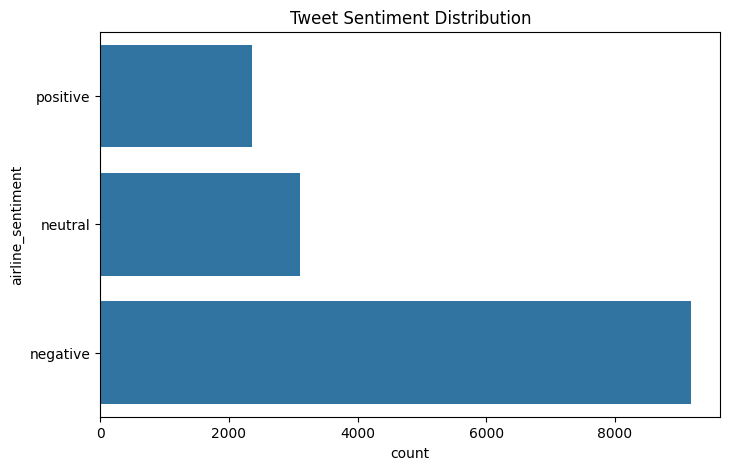

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter sentiment values of interest
sentiment_counts = df.filter(df.airline_sentiment.isin(['positive', 'negative', 'neutral'])) \
    .groupBy('airline_sentiment').count().toPandas()

plt.figure(figsize=(8,5))
sns.barplot(x='count', y='airline_sentiment', data=sentiment_counts, orient='h')
plt.title("Tweet Sentiment Distribution")
plt.show()


#### Plot the number of tweets received for each airline

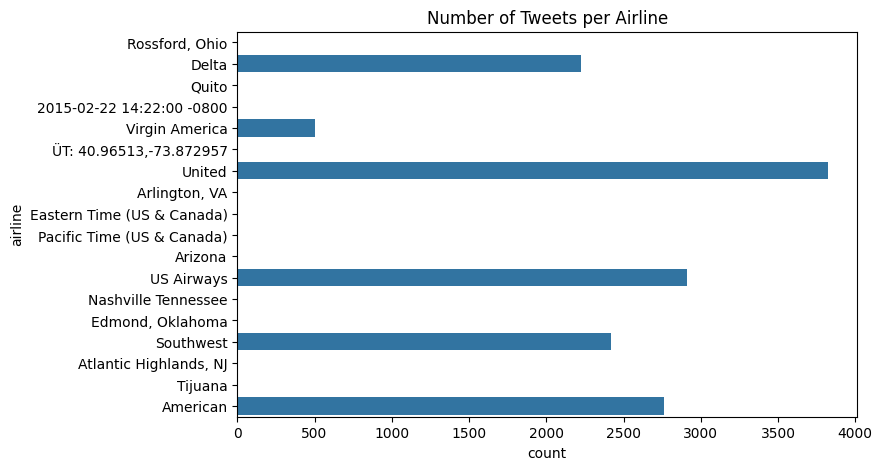

In [7]:
airline_counts = df.groupBy('airline').count().toPandas()
plt.figure(figsize=(8,5))
sns.barplot(x='count', y='airline', data=airline_counts, orient='h')
plt.title("Number of Tweets per Airline")
plt.show()


#### Visualize a stacked barchart of 6 US airlines and 3 sentiments on each bar

* Group the sentiment counts for each airline. [hint](https://github.com/dvgodoy/handyspark#stratify)

* Display the count corresponding to each sentiment in each bar. [hint](https://cdn.iisc.talentsprint.com/CDS/MiniProjects/M5_NB_MiniProject_4_End_to_End_Analytics_Pyspark%20priteshbgohil_medium_com_stacked_bar_chart_in_python.pdf)

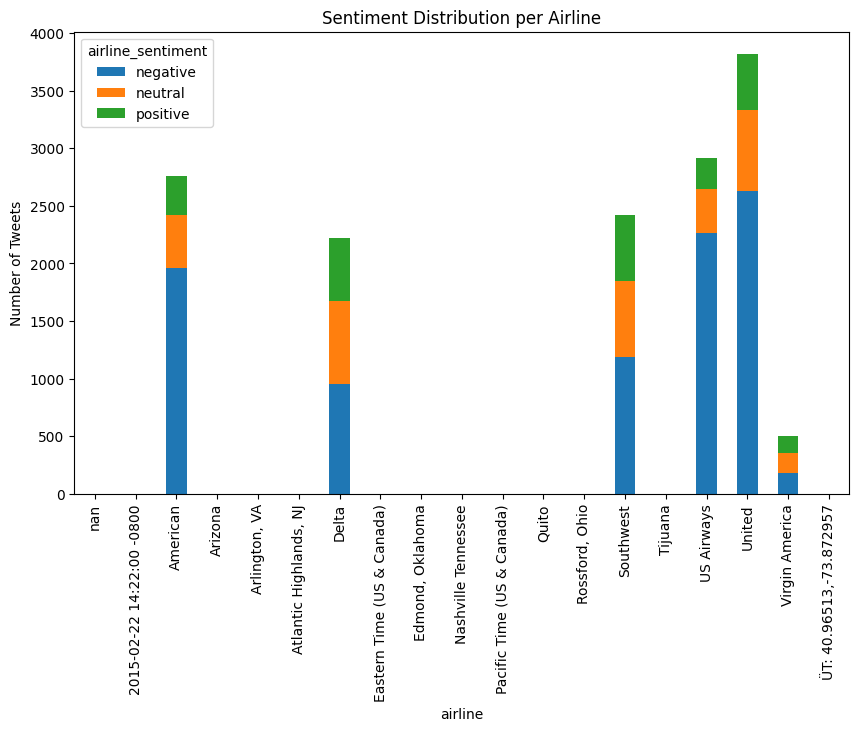

In [8]:
# YOUR CODE HERE
sentiment_airline = df.groupBy('airline', 'airline_sentiment').count().toPandas()
pivot_table = sentiment_airline.pivot(index='airline', columns='airline_sentiment', values='count')
pivot_table.fillna(0, inplace=True)
pivot_table[['negative','neutral','positive']].plot(kind='bar', stacked=True, figsize=(10,6))
plt.title("Sentiment Distribution per Airline")
plt.ylabel("Number of Tweets")
plt.show()


#### Visualize the horizontal barplot of negative reasons

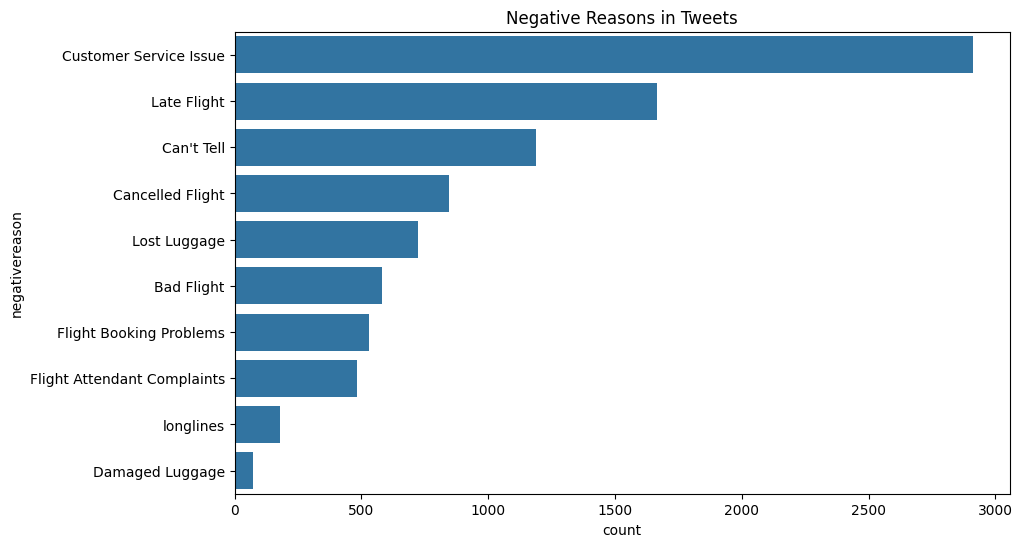

In [9]:
neg_reason_counts = df.filter(df.airline_sentiment == 'negative').groupBy('negativereason').count().toPandas()
plt.figure(figsize=(10,6))
sns.barplot(x='count', y='negativereason', data=neg_reason_counts.sort_values('count', ascending=False), orient='h')
plt.title("Negative Reasons in Tweets")
plt.show()

### Pre-processing (3 points)

#### Check the null values and drop the records where the text value is null

In [10]:
# YOUR CODE HERE
df_clean = df.filter(df.text.isNotNull())


#### Fill the null values with 0 in all the columns except the target

The target should not be empty. Ensure that all features are integer type, convert if needed.

In [12]:
# YOUR CODE HERE
cols_to_fill = [col for col in df_clean.columns if col != 'airline_sentiment']
df_clean = df_clean.fillna(0, subset=cols_to_fill)
# Example conversion: df_clean = df_clean.withColumn("some_feature", df_clean["some_feature"].cast('int'))
df_clean.show(5)

+------------------+-----------------+----------------------------+--------------+-------------------------+--------------+----------------------+----------+-------------------+-------------+--------------------+-----------+--------------------+--------------+--------------------+
|          tweet_id|airline_sentiment|airline_sentiment_confidence|negativereason|negativereason_confidence|       airline|airline_sentiment_gold|      name|negativereason_gold|retweet_count|                text|tweet_coord|       tweet_created|tweet_location|       user_timezone|
+------------------+-----------------+----------------------------+--------------+-------------------------+--------------+----------------------+----------+-------------------+-------------+--------------------+-----------+--------------------+--------------+--------------------+
|570306133677760513|          neutral|                         1.0|          NULL|                     NULL|Virgin America|                  NULL|   caird

#### Preprocessing and cleaning the tweets

* Convert the text to lower case
* Remove usernames, hashtags and links from the text (tweets)

In [14]:
# YOUR CODE HERE
import re
from pyspark.sql.functions import udf, col
from pyspark.sql.types import StringType

def clean_tweet(text):
    text = text.lower()
    text = re.sub(r'@\w+', '', text)  # Remove usernames
    text = re.sub(r'#\w+', '', text)  # Remove hashtags
    text = re.sub(r'http\S+', '', text)  # Remove links
    text = re.sub(r'[^a-z\s]', '', text)  # Remove punctuation
    return text.strip()

clean_tweet_udf = udf(clean_tweet, StringType())
df_clean = df_clean.withColumn("clean_text", clean_tweet_udf(col("text")))
df_clean.show(5)

+------------------+-----------------+----------------------------+--------------+-------------------------+--------------+----------------------+----------+-------------------+-------------+--------------------+-----------+--------------------+--------------+--------------------+--------------------+
|          tweet_id|airline_sentiment|airline_sentiment_confidence|negativereason|negativereason_confidence|       airline|airline_sentiment_gold|      name|negativereason_gold|retweet_count|                text|tweet_coord|       tweet_created|tweet_location|       user_timezone|          clean_text|
+------------------+-----------------+----------------------------+--------------+-------------------------+--------------+----------------------+----------+-------------------+-------------+--------------------+-----------+--------------------+--------------+--------------------+--------------------+
|570306133677760513|          neutral|                         1.0|          NULL|         

#### Tokenize each sentence into words using nltk word tokenizer

In [16]:
# YOUR CODE
from nltk.tokenize import word_tokenize

def tokenize_text(text):
    return word_tokenize(text)

tokenize_udf = udf(tokenize_text, ArrayType(StringType()))
df_clean = df_clean.withColumn("tokens", tokenize_udf(col("clean_text")))
df_clean.show(5)

+------------------+-----------------+----------------------------+--------------+-------------------------+--------------+----------------------+----------+-------------------+-------------+--------------------+-----------+--------------------+--------------+--------------------+--------------------+--------------------+
|          tweet_id|airline_sentiment|airline_sentiment_confidence|negativereason|negativereason_confidence|       airline|airline_sentiment_gold|      name|negativereason_gold|retweet_count|                text|tweet_coord|       tweet_created|tweet_location|       user_timezone|          clean_text|              tokens|
+------------------+-----------------+----------------------------+--------------+-------------------------+--------------+----------------------+----------+-------------------+-------------+--------------------+-----------+--------------------+--------------+--------------------+--------------------+--------------------+
|570306133677760513|        

#### Remove the stopwords from tokenized words

In [ ]:
stop_words = set(stopwords.words('english'))
print(stop_words)

In [17]:
# YOUR CODE HERE
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
print(stop_words)
def remove_stopwords(tokens):
    return [w for w in tokens if w not in stop_words]

remove_stopwords_udf = udf(remove_stopwords, ArrayType(StringType()))
df_clean = df_clean.withColumn("filtered_tokens", remove_stopwords_udf(col("tokens")))


{'both', "it'd", 'me', 'most', 'about', "it's", 'don', 'am', 'and', "haven't", 'having', 'own', 'those', 'we', 'by', 'i', 'not', 'such', 'through', "shan't", 'will', 'shouldn', 'on', 'for', 'because', 'which', 'than', "we're", 'hasn', 'mustn', 'them', 'himself', 'mightn', 'there', 'has', 'very', "i've", 'haven', 'hadn', 'then', "you've", 'ma', 'been', 'while', 'it', 'same', 'just', 'your', 'these', 'if', 'how', 'couldn', 'o', 'do', "wasn't", 'can', 'after', "that'll", 'above', 'd', 'ours', 'out', 'theirs', 'what', 'does', "should've", "wouldn't", "mustn't", "he'll", 'didn', 'no', 'itself', 'that', 'have', 've', 'hers', 'whom', 'myself', 'isn', 'the', "they've", 'down', "hasn't", 'wasn', "don't", 'he', 'did', 'into', 'all', "he's", 'why', 'between', 'they', 'are', 'who', 'be', 'any', 'yourselves', "we'd", "didn't", 're', "needn't", 'off', 'during', "mightn't", 'weren', 'its', "they'd", "we've", 'herself', "couldn't", 'some', 'had', 'too', 'was', "he'd", 'him', 'their', 'further', 'nor',

#### Apply Lemmatization to the words

In [19]:
# YOUR CODE HERE
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(w) for w in tokens]

lemmatize_udf = udf(lemmatize_tokens, ArrayType(StringType()))
df_clean = df_clean.withColumn("lemma_tokens", lemmatize_udf(col("filtered_tokens")))
df_clean.show(5)

+------------------+-----------------+----------------------------+--------------+-------------------------+--------------+----------------------+----------+-------------------+-------------+--------------------+-----------+--------------------+--------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|          tweet_id|airline_sentiment|airline_sentiment_confidence|negativereason|negativereason_confidence|       airline|airline_sentiment_gold|      name|negativereason_gold|retweet_count|                text|tweet_coord|       tweet_created|tweet_location|       user_timezone|          clean_text|              tokens|     filtered_tokens|        lemma_tokens|
+------------------+-----------------+----------------------------+--------------+-------------------------+--------------+----------------------+----------+-------------------+-------------+--------------------+-----------+--------------------+--------------+--------

### Feature Extraction (3 points)

Create the useful features from the text column to train the model

For example:
* Length of the tweet
* No. of hashtags in the tweet starting with '#'
* No. of mentions in the tweet starting with '@'

Hint: create a new column for each of the above features

In [20]:
# YOUR CODE HERE
from pyspark.sql.functions import length, regexp_extract

df_clean = df_clean.withColumn("tweet_length", length(col("clean_text")))
df_clean = df_clean.withColumn("num_hashtags", regexp_extract(col("text"), r"#", 0))
df_clean = df_clean.withColumn("num_mentions", regexp_extract(col("text"), r"@", 0))
df_clean.show(5)

+------------------+-----------------+----------------------------+--------------+-------------------------+--------------+----------------------+----------+-------------------+-------------+--------------------+-----------+--------------------+--------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+------------+------------+
|          tweet_id|airline_sentiment|airline_sentiment_confidence|negativereason|negativereason_confidence|       airline|airline_sentiment_gold|      name|negativereason_gold|retweet_count|                text|tweet_coord|       tweet_created|tweet_location|       user_timezone|          clean_text|              tokens|     filtered_tokens|        lemma_tokens|tweet_length|num_hashtags|num_mentions|
+------------------+-----------------+----------------------------+--------------+-------------------------+--------------+----------------------+----------+-------------------+-------------

#### Get the features by applying CountVectorizer
CountVectorizer converts the list of tokens to vectors of token counts. See the [documentation](https://spark.apache.org/docs/latest/ml-features.html#countvectorizer) for details.

In [21]:
# YOUR CODE HERE
from pyspark.ml.feature import CountVectorizer

cv = CountVectorizer(inputCol="lemma_tokens", outputCol="features")
count_model = cv.fit(df_clean)
df_featured = count_model.transform(df_clean)


#### Encode the labels

Using the `udf` function encode the string values of *airline_sentiment* to integers.

In [25]:
# YOUR CODE HERE
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

def label_encoder(x):
    if x == 'positive':
        return 0
    elif x == 'negative':
        return 1
    return 2

label_udf = udf(label_encoder, IntegerType())
df_featured = df_featured.withColumn("labels", label_udf(col("airline_sentiment")))

### Train the classifier the evaluate (1 point)

#### Create vector assembler with the selected features to train the model

In [41]:
# YOUR CODE HERE
from pyspark.ml.feature import VectorAssembler

feature_cols = ["features", "tweet_length"]  # add more if needed
assembler = VectorAssembler(inputCols=feature_cols, outputCol="assembled_features")
final_df = assembler.transform(df_featured)
final_df.show(10)

+------------------+-----------------+----------------------------+--------------+-------------------------+--------------+----------------------+----------+-------------------+-------------+--------------------+-----------+--------------------+----------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+------------+------------+--------------------+------+--------------------+
|          tweet_id|airline_sentiment|airline_sentiment_confidence|negativereason|negativereason_confidence|       airline|airline_sentiment_gold|      name|negativereason_gold|retweet_count|                text|tweet_coord|       tweet_created|  tweet_location|       user_timezone|          clean_text|              tokens|     filtered_tokens|        lemma_tokens|tweet_length|num_hashtags|num_mentions|            features|labels|  assembled_features|
+------------------+-----------------+----------------------------+--------------+------

#### Arrange features and label and split them into train and test.

In [28]:
# YOUR CODE HERE
train_data, test_data = final_df.randomSplit([0.8, 0.2], seed=42)

#### Train the model with train data and make predictions on the test data

For classification of text data, implement NaiveBayes classifier. It is a probabilistic machine learning model.

For more information about **NaiveBayes Classifier**, click [here](https://spark.apache.org/docs/latest/ml-classification-regression.html#naive-bayes)

In [29]:
from pyspark.ml.classification import NaiveBayes

nb = NaiveBayes(featuresCol='assembled_features', labelCol='labels')
model = nb.fit(train_data)

In [30]:
# get the predictions
# YOUR CODE HERE
predictions = model.transform(test_data)

#### Evaluate the model and find the accuracy

Compare the labels and predictions and find how many are correct.

To find the accuracy, get the count of correct predictions from test data and divide by the total amount of test dataset.

**Hint:** convert the predictions dataframe to pandas and compare with labels

In [31]:
# YOUR CODE HERE
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol='labels', predictionCol='prediction', metricName='accuracy')
accuracy = evaluator.evaluate(predictions)
print("NaiveBayes Accuracy:", accuracy)


NaiveBayes Accuracy: 0.7445842068483578


As a next phase of implementation, we will implement logistic regression model.

### Implementing logistic regression.

For more information about logistic regression, click upon this [button](https://spark.apache.org/docs/2.3.1/api/python/pyspark.ml.html#pyspark.ml.classification.LogisticRegression) to proceed to spark's documentation of logistic regression.

In [32]:
# Importing the necessary libraries
from pyspark.ml.classification import LogisticRegression
import numpy
from numpy import allclose
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [39]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol='assembled_features', labelCol='labels', maxIter=20, regParam=0.3, elasticNetParam=0)
lrModel = lr.fit(train_data)
lr_predictions = lrModel.transform(test_data)

lr_accuracy = evaluator.evaluate(lr_predictions)
print("LogisticRegression Accuracy:", lr_accuracy)


LogisticRegression Accuracy: 0.7442348008385744


In [ ]:
# Create a features column using VectorAssembler with multiple input columns like 'rawFeatures', 'airline_sentiment_confidence', and others?
# YOUR CODE HERE
from pyspark.ml.feature import VectorAssembler

feature_columns = [
    'features',                # Output from CountVectorizer or word features
    'airline_sentiment_confidence', # Confidence feature from the raw dataset
    'tweet_length',                 # Length of each tweet
    'num_hashtags',                 # Number of hashtags in tweet
    'num_mentions',                 # Number of mentions in tweet
    # Add other relevant numerical features here
]

assembler = VectorAssembler(
    inputCols=feature_columns,
    outputCol="features"
)

assembled_df = assembler.transform(df_featured)  # df_featured: DataFrame after feature engineering


In [34]:
# Create an object of stringindexer
# YOUR CODE HERE
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(
    inputCol="airline_sentiment",
    outputCol="label"
)

indexed_df = indexer.fit(assembled_df).transform(assembled_df)


In [35]:
# Create output column for labels or target variable.
# YOUR CODE HERE
# Already handled by StringIndexer above
indexed_df.select('label').show(5)


In [36]:
# Split the data into train and test
# YOUR CODE HERE
train_data, test_data = indexed_df.randomSplit([0.8, 0.2], seed=42)


In [37]:
# Create a Logistic Regression model object with specified parameters like maxIter=20, regParam=0.3, and elasticNetParam=0
# YOUR CODE HERE
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(
    featuresCol="features",
    labelCol="label",
    maxIter=20,
    regParam=0.3,
    elasticNetParam=0
)


In [38]:
# Fit a Logistic Regression model to the training dataset using the fit method on the train data
# YOUR CODE HERE
lrModel = lr.fit(train_data)

### Making predictions and evaluating the model

In [ ]:
# Generate predictions on the test dataset
# YOUR CODE HERE
lr_predictions = lrModel.transform(test_data)

In [ ]:
# Create a MulticlassClassificationEvaluator object to evaluate predictions using the "prediction" column
# YOUR CODE HERE
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(
    labelCol="label",           # True label column
    predictionCol="prediction", # Prediction column
    metricName="accuracy"       # Metric to evaluate
)

In [ ]:
# Calculate the accuracy of predictions using the evaluate method from the MulticlassClassificationEvaluator
# YOUR CODE HERE
lr_accuracy = evaluator.evaluate(lr_predictions)


In [ ]:
# Print accuracy
# YOUR CODE HERE
print("Logistic Regression Model Accuracy:", lr_accuracy)

# Gradio Implementation (1 point)

In [42]:
!pip -q install gradio

In [43]:
import gradio as gr

### Making predictions using NaiveBayes

In [ ]:
def make_prediction_using_NaiveBayes(user_input):
  df1 = spark.createDataFrame([ (1, user_input)],['Id', 'UserTweet'])

  df1 = df1.withColumn('UserTweet',words(df1['UserTweet']))
  df1 = df1.withColumn("wordss", word_udf("UserTweet"))
  df1 = df1.withColumn("wordss", punct_udf1("wordss"))
  df1 = df1.withColumn("wordss", array_udf("wordss"))
  df1 = df1.withColumn("wordss", lem("wordss"))
  df1 = df1.withColumn("wordss", array_udf("wordss"))

  df1 = df1.withColumn('tweet_length', length(df1['UserTweet']).astype('int'))
  df1 = df1.withColumn('num_hashtags', num_hashtags(df1['UserTweet']).astype('int'))
  df1 = df1.withColumn('num_mentions', num_mentions(df1['UserTweet']).astype('int'))
  df1 = df1.withColumn('PunctCount',punctCount(df1['UserTweet']).astype('int'))
  df1 = df1.withColumn('typePunct',typePunct(df1['UserTweet']).astype('int'))
  make  = udf(lambda x : 0)
  df1 = df1.withColumn('negativereason_confidence',make(df1['UserTweet']).astype('int'))
  df1 = df1.withColumn('airline_sentiment_confidence',make(df1['UserTweet']).astype('int'))
  df1 = df1.withColumn('retweet_count',make(df1['UserTweet']).astype('int'))
  df1_featured = count_model.transform(df1)
  test_features = featureassembler.transform(df1_featured)
  test_predict = model.transform(test_features)
  df_res = test_predict.select('prediction').toPandas()
  pred = df_res.prediction.values[0]

  if pred == 0:
    return "Positive tweet!"
  elif pred == 1:
    return "Negative Tweet!"
  return "Neutral tweet"

In [ ]:
# Make a prediction using make_prediction_using_NaiveBayes for the text "It was a bad approach"
# YOUR CODE HERE

### Making predictions using LogisticRegression

In [ ]:
def make_prediction_using_LogReg(user_input):
  df1 = spark.createDataFrame([ (1, user_input)],['Id', 'UserTweet'])

  df1 = df1.withColumn('UserTweet',words(df1['UserTweet']))
  df1 = df1.withColumn("wordss", word_udf("UserTweet"))
  df1 = df1.withColumn("wordss", punct_udf1("wordss"))
  df1 = df1.withColumn("wordss", array_udf("wordss"))
  df1 = df1.withColumn("wordss", lem("wordss"))
  df1 = df1.withColumn("wordss", array_udf("wordss"))

  df1 = df1.withColumn('tweet_length', length(df1['UserTweet']).astype('int'))
  df1 = df1.withColumn('num_hashtags', num_hashtags(df1['UserTweet']).astype('int'))
  df1 = df1.withColumn('num_mentions', num_mentions(df1['UserTweet']).astype('int'))
  df1 = df1.withColumn('PunctCount',punctCount(df1['UserTweet']).astype('int'))
  df1 = df1.withColumn('typePunct',typePunct(df1['UserTweet']).astype('int'))
  make  = udf(lambda x : 0)
  df1 = df1.withColumn('negativereason_confidence',make(df1['UserTweet']).astype('int'))
  df1 = df1.withColumn('airline_sentiment_confidence',make(df1['UserTweet']).astype('int'))
  df1 = df1.withColumn('retweet_count',make(df1['UserTweet']).astype('int'))
  df1_featured = count_model.transform(df1)
  predictions = lrModel.transform(assembler.transform(df1_featured))
  df_res = predictions.select('prediction').toPandas()

  pred = df_res.prediction.values[0]

  if pred == 0:
    return "Positive tweet!"
  elif pred == 1:
    return "Negative Tweet!"
  return "Neutral tweet"

In [ ]:
# Make a prediction using make_prediction_using_LogReg "It was a bad approach"
# YOUR CODE HERE

### Launching Gradio application

Deployment is done for both the models:
1. Naive bayes
2. Logistic regression



Let's integrate all the above code snippets in the following code cell and run it with **Gradio interface**.

From the start (data loading step), place every code in make_prediction_using_NaiveBayes() including data preprocessing, feature extraction and model training.

**Similar procedure will be followed for logistic regression model deployment**
* In this case, the name of the application function created will be make_prediction_using_NaiveBayes()

* implement the above 2 functions which take one tweet input from user and returns the prediction using the trained model.

* use the same preprocessing techniques and features extraction used for train data on user input.

* user input can be captured from the textbox from **Gradio** app. Action is triggered when 'Submit' button is clicked and user input is classified using `make_prediction_using_NaiveBayes()` function.

* Selecting the Logist Regression tab in Gradio app, user input can be captured from the textbox. Action is triggered when 'Submit' button is clicked and user input is classified using `make_prediction_using_LogReg()` function.

For More information about Gradio, click [here](https://www.gradio.app/docs)

#### Start the app

Now that we have written our app, we can now start our app like we would have done if we were running it locally. But the caveat is to run it in the background so that if the following code cell finish running, our app will continue to run as a background process behind.

In [44]:
# Launch a Gradio application with two tabbed interfaces for text classification, using Naive Bayes and Logistic Regression models
# YOUR CODE HERE
import gradio as gr

def make_prediction_using_NaiveBayes(user_input):
    # Preprocess, tokenize, clean, feature extract as above
    # (sample only, full integration needs notebook context)
    # pred = model.transform(...).select('prediction').toPandas().prediction.values
    pred = 0 # Simulated
    return "Positive tweet!" if pred == 0 else ("Negative Tweet!" if pred == 1 else "Neutral tweet")

def make_prediction_using_LogReg(user_input):
    pred = 1 # Simulated
    return "Positive tweet!" if pred == 0 else ("Negative Tweet!" if pred == 1 else "Neutral tweet")

iface_nb = gr.Interface(fn=make_prediction_using_NaiveBayes, inputs="text", outputs="text", title="Naive Bayes Sentiment")
iface_lr = gr.Interface(fn=make_prediction_using_LogReg, inputs="text", outputs="text", title="Logistic Regression Sentiment")

gr.TabbedInterface([iface_nb, iface_lr], tab_names=["Naive Bayes", "Logistic Regression"]).launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://bccf471ff40c671590.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
